<a href="https://colab.research.google.com/github/vivekbansal1977/ML/blob/main/reMars22_Latitudo40_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML for city-level Carbon Neutrality analysis
**Estimate Carbon Storage capacity of Las Vegas and analyze its carbon neutrality knowing its carbon footprint**

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup-Env)
1. [Preliminary tutorial](#Let's-know-Python-tools-we'll-use)
1. [Carbon Storage Estimation with Invest Model](#Carbon-Storage-estimation-with-Invest-model)
1. [ML for Carbon Pools estimation](#Machine-Learning-for-precise-Carbon-Pools-estimation-on-Las-Vegas)
1. [Las Vegas Carbon footprint](#Las-Vegas-Carbon-Footprint)
1. [Evaluate Carbon Neutrality](#Evaluate-Carbon-Neutrality)

## Setup Env

Let's start by:
* installing Python libraries we need
* retrieve info we need to execute following code 

### Libraries installation
please be sure to install libraries properly.

In [1]:
# IMPORTANT! Install this library BEFORE proceeding with the next cells.
# Run the cell 2 times to be sure the second time you'll receive 
# the message "Requirement already satisfied [...]"

# If you have problems please execute this cell and after restart the kernel

!pip install MarkupSafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Please ensure you have ran the above cell twice and you have received the message "Requirement already satisfied: MarkupSafe==2.0.1" in the second. Do not proceed without the message. You will encounter import errors.**

In [2]:
!pip install rioxarray xarray geopandas shapely fsspec[s3] folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 14.5 MB/s 
     |████████████████████████████████| 140 kB 55.1 MB/s 
     |████████████████████████████████| 6.3 MB 39.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 16.7 MB 451 kB/s 
     |████████████████████████████████| 64 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 34.9 MB/s 
     |████████████████████████████████| 8.6 MB 47.0 MB/s 
     |████████████████████████████████| 144 kB 79.6 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 68.4 MB/s 
     |████████████████████████████████| 127 kB 67.1 MB/s 
  Created wheel for rioxarr

### Retrieve Latitudo 40 API token
we'll retrieve API token to be able to call Latitudo 40 APIs.
Token has already been stored in [AWS Secret Manager](https://aws.amazon.com/secrets-manager/). 

N.B.: The token will be active for all duration of the workshop.

In [3]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 8.2 MB/s 
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 9.0 MB 60.9 MB/s 
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.21
    Uninstalling botocore-1.24.21:
      Successfully uninstalled botocore-1.24.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.3.4 requires botocore<1.24.22,>=1.24.21, but you have botocore 1.27.38 which is incompatible.


In [6]:
import boto3

client = get_boto3_client('s3')
#client = boto3.client('SSM')

response = client.get_parameter(
    Name='rds.us-west-1.api.aws'
)

region_name = response['Parameter']['Value'] # US West (N. California)

NameError: ignored

In [ ]:
# Read api token from secret manager
import boto3

client = boto3.client('acm')

response = client.get_secret_value(
            SecretId='l40-api-token')


api_token = response['SecretString']

In [ ]:
## Setup bucket name
bucket = "l40-remars22"

## Import Libraries

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 9.2 MB/s 
     |████████████████████████████████| 16.7 MB 46.9 MB/s 
     |████████████████████████████████| 6.3 MB 51.2 MB/s 


In [ ]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 114.0 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=e08c5a69acc6a5cc5a128da2df9d3d0aafd9daa1dcd3d33cfe0790bea45782e7
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [ ]:
!pip install fsspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.2 MB/s 


In [ ]:
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import fsspec
import folium
import pandas as pd
import datetime
from pathlib import Path 


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Let's know Python tools we'll use
This section we will familiarize ourselves with images, data structures, and Python libraries we'll extensively use during this workshop. 
We'll know the most used Python tools in every geospatial data analysis.

### fsspec: Filesystem interfaces for Python
This tool is not strictly related to the geospatial ecosystem but in Latitudo 40 we use it extensively to develop code which works fine both with local and cloud storage.
When a library does not support directly reading/writing files from/to S3 buckets we use fsspec to manage cloud objects. fsspec uses boto3 in the backend to interface with S3 storage.

---

Filesystem Spec (fsspec) is a project to provide a unified pythonic interface to local, remote and embedded file systems and bytes storage.

There are many places to store bytes, from in memory, to the local disk, cluster distributed storage, to the cloud. Working with all these different storage media, and their associated libraries, is painful. fsspec provides a familiar API that will work the same whatever the storage backend.


read more at https://filesystem-spec.readthedocs.io/

In [ ]:
!pip install s3fs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.2 MB/s 
     |████████████████████████████████| 64 kB 3.9 MB/s 
     |████████████████████████████████| 8.6 MB 37.7 MB/s 
     |████████████████████████████████| 144 kB 32.6 MB/s 
     |████████████████████████████████| 271 kB 76.2 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.23
    Uninstalling botocore-1.27.23:
      Successfully uninstalled botocore-1.27.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.24.23 requires botocore<1.28.0,>=1.27.23, but you have botocore 1.24.21 which is incompatible.


In [ ]:
# test access to S3 bucket

def print_file(filepath):
    # with fsspec we can open a remote file like a local file.
    with fsspec.open(filepath, anon=True) as file:
        file_content = file.read()
        print(file_content)
        
readme_filepath = f"s3://{bucket}/las_vegas/readme.md"  
print_file(readme_filepath)

b'Bucket for the workshop "Using AI/ML & satellite imagery to achieve city-level carbon neutrality" at AWS ReMars 2022 - Latitudo 40\n'


In [ ]:
# download file locally
readme_filepath_local = "readme.md"
fs, fs_token, paths = fsspec.get_fs_token_paths(readme_filepath)  # get filesystem class from filepath
fs.get_file(readme_filepath, readme_filepath_local)

print_file(readme_filepath_local) # note how print_file function with a local file too

### Gis Spatial data types
When we come to depict any spatial data, there are two differing systems to display data:
* **Vector**: Vector data is what most people think of when they consider spatial data.  Data in this format consists of points, lines or polygons.  At its simplest level, vector data comprises of individual points stored as coordinate pairs that indicate a physical location in the world. 

* **Raster**: Raster data provides a representation of the world as a surface divided up into a regular grid array, or cells, where each of these cells has an associated value.  A digital photograph is an example of a raster dataset. The main point of difference between the digital photograph and the GIS representation is that in the GIS there is accompanying data detailing where the cells can be found on a globe and how big these cells can be.

---

#### Read Area of Interest (AoI) of Las Vegas with Geopandas

In the Python ecosystem, **Geopandas** and **Shapely** are the main libraries to deal with vector data. In this section, we will read a [geojson](https://geojson.org/) file containing the Area of Interest in Las Vegas. This area will be the area we will analyze in this notebook.

Simplifying, Geopandas is the geospatial extension of the Pandas library.


In [ ]:
aoi_filepath = f"s3://{bucket}/las_vegas/las_vegas.geojson"

# with fsspect we are able to read a geojson file from an S3 bucket with geopands like it was a local file. 
# We don't need to change the code if we switch to a local file
with fsspec.open(aoi_filepath, anon=True) as file:
    aoi_geodf = gpd.read_file(file)

aoi_geodf

NameError: ignored

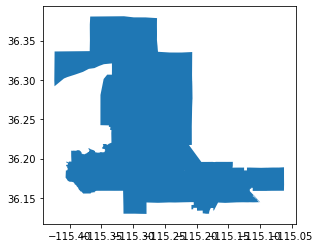

In [ ]:
# plot AoI geometry
aoi_geodf.plot()

#### Xarray and Rioxarray: Read raster data of Las Vegas

In a general way, we can handle raster data as a **Multi-dimensional** (a.k.a. N-dimensional, ND) arrays (sometimes called “tensors”) are an essential part of computational science. In Python, NumPy provides the fundamental data structure and API for working with raw ND arrays. However, real-world datasets are usually more than just raw numbers; they have labels which encode information about how the array values map to locations in space, time, etc.

[**Xarray**](https://docs.xarray.dev/en/stable/) is a Python library that help us to manage raster data with N-dimensional arrays. The N-dimensional nature of xarray’s data structures makes it suitable for dealing with multi-dimensional scientific data, and its use of dimension names instead of axis labels (dim='time' instead of axis=0) makes such arrays much more manageable than the raw numpy ndarray.

Xarray provides two data structures: the **DataArray** and **Dataset**. The DataArray class attaches dimension names, coordinates and attributes to multi-dimensional arrays while Dataset combines multiple arrays.

Here is an example of how we might structure a dataset for a weather forecast:
![xarray dataset](http://xarray.pydata.org/en/stable/_images/dataset-diagram.png "Title")

---
---

In the next cell we'll read raster data of Las Vegas with the [**Rioxarray**](https://corteva.github.io/rioxarray/stable/) library. Rioxarray is built on top of Xarray and [Rasterio](https://rasterio.readthedocs.io/en/latest/) to read geospatial raster data.

In particular, we'll visualize RGB photos of Las Vegas derived from **Sentinel-2** satellite imagery. Sentinel-2 is an Earth observation mission from the European Copernicus Programme that systematically acquires optical imagery at high spatial resolution (10 m to 60 m). The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with **12 spectral channels** in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). Within the 13 bands, the 10 meter spatial resolution allow high-resolution land classification.
Following a list of the bands we have in Sentinel-2 products:

* Band 1 – Coastal aerosol
* Band 2 – Blue
* Band 3 – Green	
* Band 4 – Red	
* Band 5 – Vegetation red edge	
* Band 6 – Vegetation red edge
* Band 7 – Vegetation red edge
* Band 8 – NIR	
* Band 8A – Narrow NIR	
* Band 9 – Water vapour
* Band 10 – SWIR – Cirrus
* Band 11 – SWIR
* Band 12 – SWIR

In [ ]:
# read Sentinel-2 RGB data
visual_raster_20180705_path = f"s3://{bucket}/las_vegas/sentinel-s2/2018/7/5/visual_20180705.tif"

visual_raster_20180705_data = rxr.open_rasterio(filename=visual_raster_20180705_path, masked=True)
visual_raster_20180705_data

RasterioIOError: ignored

In [ ]:
# with the robust=True argument, we can display values between the 2nd and 98th percentile, 
# providing better color contrast
visual_raster_20180705_data.squeeze().plot.imshow(robust=True)

NameError: ignored

We can easily manage multi-dimensional data to deal with timeseries data. In the following cells we'll read a new raster image and will concat it with the previous one, adding a new "time" dimension.

In [ ]:
visual_raster_20180819_path = f"s3://{bucket}/las_vegas/sentinel-s2/2018/8/19/visual_20180819.tif"

visual_raster_20180819_data = rxr.open_rasterio(filename=visual_raster_20180705_path, masked=True)

# we add time dimension
visual_raster_20180705_data.expand_dims(time=[datetime.datetime.strptime("2018-07-05", "%Y-%m-%d")])
visual_raster_20180819_data.expand_dims(time=[datetime.datetime.strptime("2018-08-19", "%Y-%m-%d")])

timeseries = xr.concat([visual_raster_20180705_data, visual_raster_20180819_data], "time")
timeseries


RasterioIOError: ignored

#### Interactive maps in a Jupyter notebook
In the previous cells we plotted both vector data and raster data. However plotting those data in the usual way, i.e., using matplotlib charts, produce not so clear data visualization representation. 
Now we'll try to plot data using interacative maps. 

Interactive Maps are useful for earth data science because they:

* Clearly convey complex information.
* Are more engaging for viewers than static maps.

Here we'll use the [**Folium**](https://python-visualization.github.io/folium/) library. This package is build on top off the JavaScript library called [**leaflet.js**](https://leafletjs.com/).

---

You can make an interactive map with folium using just one line of code!

You can use the Map() function from folium and providing a latitude and longitude to center the map. The map is created using the default basemap from OpenStreetMap.

In [ ]:
# Create a map using the Map() function and the coordinates for Las Vegas
las_vegas_centroid = [36.241859, -115.272147]
m = folium.Map(location=las_vegas_centroid)

# Display the map
m

##### Change Basemap

We can change the basemap for the map by providing a value for the tiles parameter of the Map() function.
There are many different options including Stamen Terrain, Stamen Toner and cartodbpositron.

In [ ]:
m = folium.Map(location=las_vegas_centroid, tiles='CartoDB positron')

# Display the map
m

##### Add Markers

We can also add markers to label specific points on top of a folium basemap, such as the coordinates that are being used to center the map. We can even add a pop-up label for the marker that is activated when you click on it.

In [ ]:
# Add marker for Boulder, CO
folium.Marker(
    location=las_vegas_centroid, # coordinates for the marker (Las Vegas centroid)
    popup='Las Vegas', # pop-up label for the marker
    icon=folium.Icon()
).add_to(m)

# Display m
m

Now we can plot the AoI of Las Vegas with Folium

In [ ]:
m = folium.Map(location=las_vegas_centroid, zoom_start=11, tiles='CartoDB positron') # create basemap with Folium

# add geometry on the map
for _, r in aoi_geodf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'oramge'})
    folium.Popup(r['full_id']).add_to(geo_j)
    geo_j.add_to(m)

m

##### Raster Overlay on Interactive Map

We can also overlay rasters on folium basemaps.

The default coordinate system and projection for web-based basemaps is WGS84 Web Mercator. To overlay data on web-based basemaps, the overlay data needs to be in the WGS84 coordinate system.
Thus, to overlay a raster on a basemap, we first need to project the raster to WGS84 (EPSG 4326).

---

Folium is powerful, but we still need to prepare the raster before we can plot it.

The first thing we must do is replace all the nan values that rioxarray used to mask out areas with no data. These values don’t work with folium. In this case, you can replace those values with the minimum value in the image, but you can replace them with whatever values you see fit to best visualize your data.

The next thing we must do is scale the data to only contain values from 0 to 255. 


In [ ]:
# source: https://earthpy.readthedocs.io/en/latest/_modules/earthpy/spatial.html#bytescale

def bytescale(data, high=255, low=0, cmin=None, cmax=None):
    """Byte scales an array (image).
    Byte scaling converts the input image to uint8 dtype, and rescales
    the data range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    Source code adapted from scipy.misc.bytescale (deprecated in scipy-1.0.0)
    Parameters
    ----------
    data : numpy array
        image data array.
    high : int (default=255)
        Scale max value to `high`.
    low : int (default=0)
        Scale min value to `low`.
    cmin : int (optional)
        Bias scaling of small values. Default is ``data.min()``.
    cmax : int (optional)
        Bias scaling of large values. Default is ``data.max()``.
    Returns
    -------
    img_array : uint8 numpy array
        The byte-scaled array.
    Examples
    --------
        >>> import numpy as np
        >>> from earthpy.spatial import bytescale
        >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
        ...                 [ 73.88003259,  80.91433048,   4.88878881],
        ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
        >>> bytescale(img)
        array([[255,   0, 236],
               [205, 225,   4],
               [140,  90,  70]], dtype=uint8)
        >>> bytescale(img, high=200, low=100)
        array([[200, 100, 192],
               [180, 188, 102],
               [155, 135, 128]], dtype=uint8)
        >>> bytescale(img, cmin=0, cmax=255)
        array([[255,   0, 236],
               [205, 225,   4],
               [140,  90,  70]], dtype=uint8)
    """
    if data.dtype == "uint8":
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None or (cmin < data.min()):
        cmin = float(data.min())

    if (cmax is None) or (cmax > data.max()):
        cmax = float(data.max())

    # Calculate range of values
    crange = cmax - cmin
    if crange < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif crange == 0:
        raise ValueError(
            "`cmax` and `cmin` should not be the same value. Please specify "
            "`cmax` > `cmin`"
        )

    scale = float(high - low) / crange

    # If cmax is less than the data max, then this scale parameter will create
    # data > 1.0. clip the data to cmax first.
    data[data > cmax] = cmax
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype("uint8")

In [ ]:

# Scale the array from 0 to 255
visual_raster_20180705_data_plot = visual_raster_20180705_data.where(~visual_raster_20180705_data.isnull(), visual_raster_20180705_data.min())

scaled_img = bytescale(visual_raster_20180705_data_plot.values[0])
start_bound_x, start_bound_y, end_bound_x, end_bound_y =  visual_raster_20180705_data.rio.bounds()

# Overlay raster called img using add_child() function (opacity and bounding box set)
map_bounds = [[start_bound_y, start_bound_x], 
              [end_bound_y, end_bound_x]]

# -115.6644120549999997,36.1266345540000060 : -114.8371772720000052,36.3811347629999986

# Sometimes with huge raster the kernel crash with low memory problem
# m.add_child(folium.raster_layers.ImageOverlay(scaled_img, 
#                                               opacity=1,
#                                               bounds=map_bounds))
# m

NameError: ignored

## Carbon Storage estimation with Invest model

Ecosystems regulate Earth’s climate by adding and removing greenhouse gases (GHGs) such as CO2 from the atmosphere. Forests, grasslands, peat swamps, and other terrestrial ecosystems collectively store much more carbon than does the atmosphere (Lal 2002). By storing this carbon in wood, other biomass, and soil, ecosystems keep CO2 out of the atmosphere, where it would contribute to climate change. Beyond just storing carbon, many systems also continue to accumulate it in plants and soil over time, thereby “sequestering” additional carbon each year. Disturbing these systems with fire, disease, or vegetation conversion (e.g., land use/land cover (LULC) conversion) can release large amounts of CO2. Other management changes, like forest restoration or alternative agricultural practices, can lead to the storage of large amounts of CO2. Therefore, the ways in which we manage terrestrial ecosystems are critical to regulating our climate.

The social value of a sequestered ton of carbon is equal to the social damage avoided by not releasing the ton of carbon into the atmosphere (Tol 2005, Stern 2007).

Terrestrial ecosystems, which store more carbon than the atmosphere, are vital to influencing carbon dioxide-driven climate change. 

---

Carbon storage on a land parcel largely depends on the sizes of four carbon pools: 
* **aboveground biomass**: comprises all living plant material above the soil (e.g., bark, trunks, branches, leaves)
* **belowground biomass**: encompasses the living root systems of aboveground biomass
* **soil**: Soil organic matter is the organic component of soil, and represents the largest terrestrial carbon pool
* **dead organic matter**: includes litter as well as lying and standing dead wood

The InVEST Carbon Storage and Sequestration model aggregates the amount of carbon stored in these pools according to land use maps and classifications provided by the user.
Using maps of LULC classes and the amount of carbon stored in carbon pools, this model estimates the net amount of carbon stored in a land parcel over time

---


Mandatory inputs for the model:
* **Current LULC** (raster): A map of LULC for the current scenario. All values in this raster must have corresponding entries in the Carbon Pools table.

* **Carbon Pools** (CSV): A table that maps each LULC code to carbon pool data for that LULC type. If information on some carbon pools is not available, pools can be estimated from other pools, or omitted by leaving all values for the pool equal to 0.

In this workshop we have already prepared for you the input we need for the model.

read more about the model on the [official documentation](https://invest-userguide.readthedocs.io/en/latest/carbonstorage.html)

### Get LULC raster with API call

In Latitudo 40 we developed a **deep-learning** algorithm for land cover classification from Sentinel-2 satellite imagery. The model is based on an ensemble of ResNet models, which work on different multispectral bands of the Sentinel-2 data. 
We make several predictions on the same area throughout the year and finally decide to choose the class with the majority. 


We created a dataset from scratch using several data sources (OpenStreetmap, [Esri Land Cover](https://planetarycomputer.microsoft.com/dataset/io-lulc), hand-labelled data, ...)

---
In this workshop, we will not go through the deep-learning model Latitudo 40 developed, but we will use Latitudo 40 API to retrieve the already computed LULC raster for Las Vegas. 
Our model produce a classification based on the following **11 classes**:

1. water
1. trees
1. grass
1. flooded_veg
1. crops
1. scrub
1. built_area
1. bare
1. snow_ice
1. clouds
1. green_urban_area


In [ ]:
# api_token = "cmVtYXJzMjJAbGF0aXR1ZG80MC5jb206TGFzVmVnYXNfMjI="

import requests

url = "https://hub-stage.earthalytics.com/api/v1/get-image/"

lulc_filepath = "lclu.tif"

querystring = {"area_id":"d6a3b8c0-a07f-4cfa-b493-a38b25eff652","date":"2021-06-14","item_service":"lclu"}
payload = ""
headers = {'Authorization': f"cmVtYXJzMjJAbGF0aXR1ZG80MC5jb206TGFzVmVnYXNfMjI="}

response = requests.request("GET", url, data=payload, headers=headers, params=querystring)

with open(lulc_filepath, "wb") as f:
    f.write(response.content)

In [ ]:
lulc_data = rxr.open_rasterio(https://hub-stage.earthalytics.com/api/v1/get-image/)
lulc_data

SyntaxError: ignored

In the next cell, we will plot the raster. As you can see, most of the area is classified with class 7, which corresponds to the "built_area" class, as we expect for the Las Vegas city center. In addition, you can also note little yellow points (class 11), which correspond to urban green areas. 

In [ ]:
lulc_data.plot()

NameError: ignored

### Carbon Pools
The "carbon pools" table is the core part of the InVest model. We need to specify, for every class, the sizes of the four carbon pools we described above. 
We provided you with a generic carbon pools table that should work to make a generic analysis using "default" values. Those values have been collected from current literature on the topic. 

In [ ]:
carbon_pools_filepath = f"s3://{bucket}/las_vegas/carbon_pools.csv"

carbon_pools_df = pd.read_csv(carbon_pools_filepath)
carbon_pools_df

,lucode,LULC_Name,C_above,C_below,C_soil,C_dead
0,0,nodata,0,0,0,0
1,1,water,0,0,0,0
2,2,trees,13,28,95,2
3,3,grass,1,1,10,0
4,4,flooded_veg,10,5,20,0
5,5,crops,3,2,8,1
6,6,scrub,1,1,10,0
7,7,built_area,0,0,0,0
8,8,bare,1,1,10,0
9,9,snow_ice,0,0,0,0


### Run InVest model

N.B.: We can't execute the next cell since we could not install natcap.invest, which depends on GDAL installation on the system. We leave here the code for documentation purposes and if you'd like to test the code on your infrastructure.

read documentation at https://invest.readthedocs.io/en/latest/api/natcap.invest.carbon.html#natcap.invest.carbon.execute


In [ ]:
NEED natcap.invest!

import natcap.invest.carbon

args = {
        "workspace_dir": "invest_run",
        "results_suffix": "test1",
        "lulc_cur_path": "<LULC filepath>",
         "carbon_pools_path": "<Carbon Pools table path>"
    
}

natcap.invest.carbon.execute(args)

SyntaxError: invalid syntax (<ipython-input-26-0618caffc7c7>, line 1)

Since we can't execute the Carbon Storage Invest model in this notebook, we have already uploaded the result of the model on the bucket for you. Let's check together raster data we obtained:

In [ ]:
carbon_storage_filepath = f"s3://{bucket}/las_vegas/carbon_storage_estimation_las_vegas.tif"

carbon_storage_data = rxr.open_rasterio(filename=carbon_storage_filepath, masked=True)
carbon_storage_data

In [ ]:
carbon_storage_data.plot()

## Machine Learning for precise Carbon Pools estimation on Las Vegas

Using generic carbon pool values for the globe is not the best approach to estimating Carbon Storage capabilities.
Carbon pools depend on the type of green specie and their age. For example, oak has carbon pool values different from pine, and a 20-years old oak is different from a 50-years old one. In addition, values change from one location to another one.
A precise carbon storage estimation needs land cover classification with more classes (e.g., classify tree species) and field surveys to estimate carbon pools in a precise way. Of course, this approach can't be fully automatable. 
In Latitudo 40, we developed an ML model to estimate Above-Ground biomass (AGB) from Sentinel-2 satellite imagery. In this way, before we estimate Carbon Storage with the Invest model, we estimate the past AGB for the Area of Interest and populate the AGB carbon pool with a value that reflects the average we estimated. This approach helps us use a value for the AGB carbon pools, which better reflects the reality.

Many literature studies **proved a correlation between multispectral indices and AGB values**. 
Spectral indices are combinations of spectral reflectance from two or more wavelengths that indicate the relative abundance of features of interest. Vegetation indices are the most popular type.
For example, the Normalized Difference Vegetation Index (NDVI) is a simple indicator that can assess whether the target being observed contains live green vegetation.

---

In this section, we will go through a complete ML pipeline. We will start creating our own dataset, and we'll try to develop an ML model that estimates AGB from multispectral indices. 
For simplicity, we'll train just some simple ML models with a simple dataset.

### Dataset creation
In this section, we'll create a dataset to train our ML model. Data from [ESA Biomass Project](https://climate.esa.int/en/projects/biomass/) will be used as ground truth for the training, while Sentinel-2 satellite imagery will be used to compute multispectral indices we will use in our model.


In [ ]:
# A function to get datetime from filename (filename example: B01_20180121.tif)
def get_datetime_from_filename(filename):
    _filename = Path(filename).stem
    year = int(_filename[4:8])
    month = int(_filename[8:10])
    day = int(_filename[10:12])
    datetime_file = datetime.datetime(year, month,day)
    
    return datetime_file

In [ ]:
# READ AGB RASTER (ground-truth data)
filepath_agb = f"s3://{bucket}/las_vegas/agb_2018.tif"
data_agb = rxr.open_rasterio(filename=filepath_agb,masked=True).astype("float")
data_agb = data_agb.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs) # crop raster data with the AoI
data_agb.name = "agb" # name data array
data_agb

<xarray.DataArray 'agb' (band: 1, y: 282, x: 407)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 36.38 36.38 36.38 36.38 ... 36.13 36.13 36.13 36.13
  * x            (x) float64 -115.4 -115.4 -115.4 ... -115.1 -115.1 -115.1
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [ ]:
print(bucket)

l40-remars22


In [ ]:
# folder where we have Sentinel-2 data
main_folder = f"s3://{bucket}/las_vegas/sentinel-s2/2018"

files_grabbed = []
fs, fs_token, paths = fsspec.get_fs_token_paths(main_folder)

protocol = fs.protocol
if isinstance(protocol, list):
    protocol = protocol[0]
print(f"filesystem protocol: {protocol}")
        
    
files_grabbed.extend(fs.glob(f"{main_folder}/**/B02*.tif"))
files_grabbed = [f"{protocol}://{path}" for path in files_grabbed]  # add protocol in the path

print("First 5 elements found: ")
print(files_grabbed[0:5])


filesystem protocol: s3


PermissionError: Access Denied

In [ ]:
datarray_list = [data_agb]

# Compute multispectral indices we will add in our dataset
for filepath in files_grabbed:
    
    # Get date from filename
    datetime_file = get_datetime_from_filename(filepath)
    datetime_str = datetime_file.strftime("%Y_%m_%d")
    print(f"{datetime_str} - {filepath}")
    
    # Read bands we need to compute multispectral indices 
    # RED
    filepath_red = filepath.replace("B02", "B04")
    data_red = rxr.open_rasterio(filename=filepath_red, masked=True).astype("float") 
    data_red = data_red.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_red = data_red.rio.reproject_match(data_agb)
    nodata = data_red.rio.nodata
    data_red = data_red.where(data_red != nodata)
    data_red.rio.write_nodata(None, encoded=True, inplace=True)
    data_red = data_red/10000
    data_red.name = f"red_{datetime_str}"
    # datarray_list.append(data_red)

    # GREEN
    filepath_green = filepath.replace("B02", "B03")
    data_green = rxr.open_rasterio(filename=filepath_green, masked=True).astype("float") 
    data_green = data_green.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_green = data_green.rio.reproject_match(data_agb)
    nodata = data_green.rio.nodata
    data_green = data_green.where(data_green != nodata)
    data_green.rio.write_nodata(None, encoded=True, inplace=True)
    data_green = data_green/10000
    data_green.name = f"green_{datetime_str}"
    # datarray_list.append(data_green)

    # BLUE
    filepath_blue = filepath.replace("B02", "B02")
    data_blue = rxr.open_rasterio(filename=filepath_blue, masked=True).astype("float") 
    data_blue = data_blue.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_blue = data_blue.rio.reproject_match(data_agb)
    nodata = data_blue.rio.nodata
    data_blue = data_blue.where(data_blue != nodata)
    data_blue.rio.write_nodata(None, encoded=True, inplace=True)
    data_blue = data_blue/10000
    data_blue.name = f"blue_{datetime_str}"
    # datarray_list.append(data_blue)

    # NIR
    filepath_nir = filepath.replace("B02", "B02")
    data_nir = rxr.open_rasterio(filename=filepath_nir, masked=True).astype("float") 
    data_nir = data_nir.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_nir = data_nir.rio.reproject_match(data_agb)
    nodata = data_nir.rio.nodata
    data_nir = data_nir.where(data_nir != nodata)
    data_nir.rio.write_nodata(None, encoded=True, inplace=True)
    data_nir = data_nir/10000
    data_nir.name = f"nir_{datetime_str}"
    # datarray_list.append(data_nir)
    
    # RED_1
    filepath_red1 = filepath.replace("B02", "B05")
    data_red1 = rxr.open_rasterio(filename=filepath_red1, masked=True).astype("float") 
    data_red1 = data_red1.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_red1 = data_red1.rio.reproject_match(data_agb)
    nodata = data_red1.rio.nodata
    data_red1 = data_red1.where(data_red1 != nodata)
    data_red1.rio.write_nodata(None, encoded=True, inplace=True)
    data_red1 = data_red1/10000
    data_red1.name = f"red1_{datetime_str}"
    # datarray_list.append(data_red1)
    
    # NIR_2
    filepath_nir2 = filepath.replace("B02", "B8A")
    data_nir2 = rxr.open_rasterio(filename=filepath_nir2, masked=True).astype("float") 
    data_nir2 = data_nir2.rio.clip(aoi_geodf.geometry.values, aoi_geodf.crs)
    data_nir2 = data_nir2.rio.reproject_match(data_agb)
    nodata = data_nir2.rio.nodata
    data_nir2 = data_nir2.where(data_nir2 != nodata)
    data_nir2.rio.write_nodata(None, encoded=True, inplace=True)
    data_nir2 = data_nir2/10000
    data_nir2.name = f"nir2_{datetime_str}"
    # datarray_list.append(data_nir)

    # compute NDVI
    data_ndvi = (data_nir-data_red)/(data_nir+data_red)
    data_ndvi.name = f"ndvi_{datetime_str}"
    datarray_list.append(data_ndvi)
    
    # compute SAVI
    L = 0.428
    data_savi = (data_nir - data_red)/(data_nir + data_red + L)*(1.0 + L)
    data_savi.name = f"savi_{datetime_str}"
    datarray_list.append(data_savi)
    
    # compute SELI
    data_seli = (data_nir2 - data_red1)/(data_nir2 + data_red1) 
    data_seli.name = f"seli_{datetime_str}"
    datarray_list.append(data_seli)
    

In [ ]:
print(f"Num elements: {len(datarray_list)}")
data_concat = xr.merge(datarray_list)
df = data_concat.to_dataframe()
df.dropna(inplace=True)
df

NameError: name 'datarray_list' is not defined

In [ ]:
index_list = ["ndvi", "savi", "seli"]

data = df.copy(deep=True)

for index in index_list:
    for year in [2018]:
      temp_df = data.filter(regex=(f"^{index}_{year}_"))
      data[f"mean_{index}_{year}"] = temp_df.mean(axis=1)
      data[f"median_{index}_{year}"] = temp_df.median(axis=1)
      data[f"std_{index}_{year}"] = temp_df.std(axis=1)
      data[f"min_{index}_{year}"] = temp_df.min(axis=1)
      data[f"max_{index}_{year}"] = temp_df.max(axis=1)
      data = data.drop(temp_df.columns ,axis=1)
    
data = data.reset_index()
data = data.drop(['band','x','y','spatial_ref'],axis=1)
data

NameError: name 'df' is not defined

In [ ]:
data.to_csv("dataset_agb.csv") # save dataset to a CSV

### ML Regression model

Regression analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome variable', or 'target') and one or more independent variables (often called 'features', 'predictors', or 'covariates'). The objective of regression in machine learning is to predict continuous values such as sales amount, quantity, temperature etc.

For this purpose we will use the PyCaret's Regression module (pycaret.regression). It is a supervised machine learning module which is used for predicting continuous values / outcomes using various techniques and algorithms. 
PyCaret's regression module has over 25 algorithms and 10 plots to analyze the performance of models. Read the [official documentation](https://pycaret.gitbook.io/docs/) for more details. 

Let's first install the pycaret python library

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.regression import *


In [ ]:
# dataset_agb_filepath = "s3://l40-remars22/las_vegas/dataset_agb.csv"
# dataset_agb = pd.read_csv(dataset_agb_filepath)
# dataset_agb = dataset_agb.drop(['Unnamed: 0'],axis=1)
dataset_agb = data
dataset_agb


In [ ]:
exp_reg_agb = setup(data = dataset_agb, target = 'agb', session_id=123) 


In [ ]:
compare_models()

## Las Vegas Carbon Footprint

A carbon footprint is the total amount of greenhouse gases (including carbon dioxide and methane) that are generated by our actions.

We got carbon footprint of Las Vegas from [here](https://www.citycarbonfootprints.info/). The method applied is described in: Moran, Daniel, et al. "Carbon footprints of 13 000 cities." Environmental Research Letters 13.6 (2018): 064041. They provide a downscaled carbon footprint into a 250 m gridded model using data on population, purchasing power, and existing subnational CF studies from the US, China, EU, and Japan.

In [ ]:
carbon_footp_filepath = f"s3://{bucket}/las_vegas/carbon_footprint_las_vegas.tif"

carbon_footp_data = rxr.open_rasterio(filename=carbon_footp_filepath, masked=True)
carbon_footp_data

In [ ]:
carbon_footp_data.plot()

In [ ]:
# compute total carbon emitted with a sum of values in all pixels
sum = carbon_footp_data.sum()
sum.values

## Evaluate Carbon Neutrality
we'll make a difference between carbon footprint of the city and the carbon storage capacity estimated to highlight areas with big difference values 

In [ ]:
carbon_storage_filepath = f"s3://{bucket}/las_vegas/carbon_storage_estimation_las_vegas2.tif"

carbon_storage_data = rxr.open_rasterio(filename=carbon_storage_filepath, masked=True)
carbon_storage_data

In [ ]:
carbon_storage_data = carbon_storage_data.rio.reproject_match(carbon_footp_data)
carbon_storage_data

In [ ]:
carbon_storage_data.plot()

In [ ]:
difference = carbon_footp_data - carbon_storage_data
difference

In [ ]:
difference.plot()

In [ ]:
# Replace all null values with the minimum value in the array
difference_plot = difference.where(~difference.isnull(), difference.min())

In [ ]:
# Scale the array from 0 to 255
scaled_img = bytescale(difference_plot.values[0])

In [ ]:
# Scale the array from 0 to 255
scaled_img = bytescale(difference_plot.values[0])
start_bound_x, start_bound_y, end_bound_x, end_bound_y =  difference.rio.bounds()

In [ ]:
# Scale the array from 0 to 255
scaled_img = bytescale(difference_plot.values[0])
start_bound_x, start_bound_y, end_bound_x, end_bound_y =  difference.rio.bounds()
# Overlay raster called img using add_child() function (opacity and bounding box set)
map_bounds = [[start_bound_y, start_bound_x], 
              [end_bound_y, end_bound_x]]

# -115.6644120549999997,36.1266345540000060 : -114.8371772720000052,36.3811347629999986
    
m.add_child(folium.raster_layers.ImageOverlay(scaled_img, 
                                              opacity=1,
                                              bounds=map_bounds))
m